In [1]:
import pandas as pd

# Load weather data
weather_df = pd.read_csv('masinga_weather_2018_2020.csv')
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Load population data with skiprows=6 because of metadata in the first 6 rows
population_df = pd.read_csv('kenya_population_data.csv', skiprows=6)
population_df['Population'] = pd.to_numeric(population_df['Population'], errors='coerce')
population_df['name'] = population_df['name'].str.strip()

# Filter for Machakos county only
population_machakos = population_df[population_df['name'] == 'Machakos'].reset_index(drop=True)

# Load water level data
water_df = pd.read_csv('masinga_water_levels.csv')

# Fix the column name if necessary (your earlier error was about '.datetime' column missing)
# Check columns to find the correct datetime column name:
print(water_df.columns)

# Assuming column name is 'datetime' or similar, if not adjust accordingly
if '.datetime' in water_df.columns:
    datetime_col = '.datetime'
elif 'datetime' in water_df.columns:
    datetime_col = 'datetime'
else:
    # Use first column as datetime, if appropriate
    datetime_col = water_df.columns[0]

# Convert datetime column to datetime type
water_df[datetime_col] = pd.to_datetime(water_df[datetime_col])

# Create a date-only column for merging
water_df['date'] = water_df[datetime_col].dt.date
weather_df['date_only'] = weather_df['date'].dt.date

# Merge weather and water levels on date
merged_df = pd.merge(weather_df, water_df, left_on='date_only', right_on='date', how='inner')

# Drop duplicate date columns to clean up
merged_df = merged_df.drop(columns=['date_only', 'date_y'])

# Add Machakos population as a constant column for analysis
merged_df['population_machakos'] = population_machakos.loc[0, 'Population']

# Inspect the final merged dataframe
print(merged_df.head())
print(merged_df.shape)


Index(['datetime', 'wse', 'wse_u'], dtype='object')
      date_x  temperature_C  precipitation_mm            datetime       wse  \
0 2018-12-28          20.34              0.69 2018-12-28 07:29:44  1052.330   
1 2019-01-24          21.40              0.00 2019-01-24 07:29:45  1051.334   
2 2019-02-20          22.73              0.27 2019-02-20 07:29:46  1049.362   
3 2019-03-19          23.91              0.04 2019-03-19 07:29:50  1045.828   
4 2019-04-15          23.77              0.06 2019-04-15 07:29:51  1043.745   

   wse_u  population_machakos  
0  0.003              1414022  
1  0.001              1414022  
2  0.009              1414022  
3  0.059              1414022  
4  0.066              1414022  
(25, 7)


In [2]:
merged_df.head()

,date_x,temperature_C,precipitation_mm,datetime,wse,wse_u,population_machakos
0,2018-12-28,20.34,0.69,2018-12-28 07:29:44,1052.330,0.003,1414022
1,2019-01-24,21.40,0.00,2019-01-24 07:29:45,1051.334,0.001,1414022
2,2019-02-20,22.73,0.27,2019-02-20 07:29:46,1049.362,0.009,1414022
3,2019-03-19,23.91,0.04,2019-03-19 07:29:50,1045.828,0.059,1414022
4,2019-04-15,23.77,0.06,2019-04-15 07:29:51,1043.745,0.066,1414022


### Water storage over time monthly average

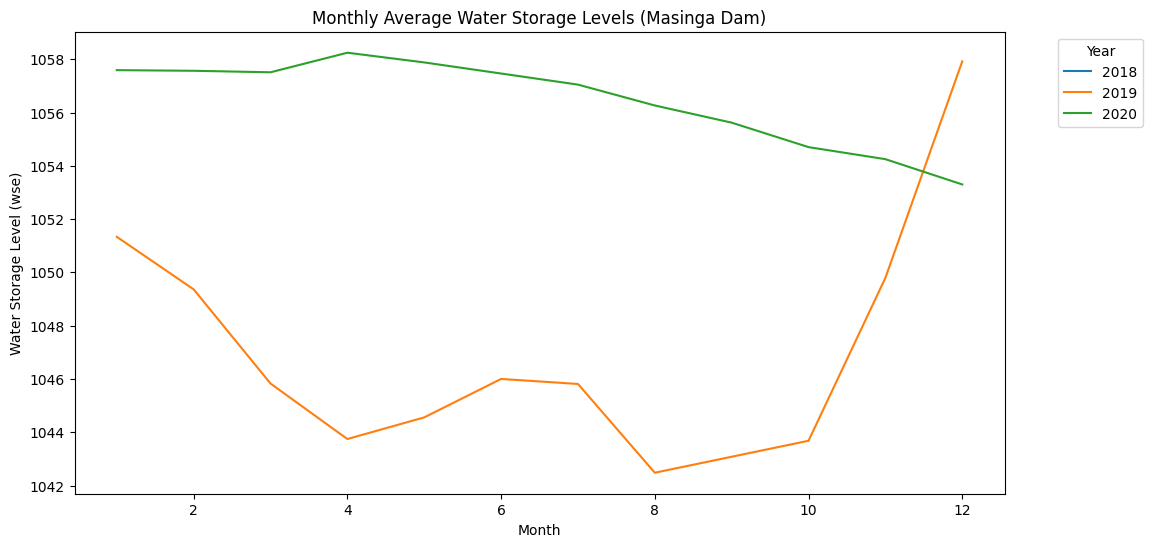

In [20]:
# Make sure datetime is datetime dtype
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])

# Extract month and year
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['year'] = merged_df['datetime'].dt.year

# Group by year and month to get average water storage level
monthly_wse = merged_df.groupby(['year', 'month'])['wse'].mean().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_wse, x='month', y='wse', hue='year', palette='tab10')
plt.title('Monthly Average Water Storage Levels (Masinga Dam)')
plt.xlabel('Month')
plt.ylabel('Water Storage Level (wse)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [8]:
import plotly.express as px
import pandas as pd

# Ensure datetime column is in datetime format
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])

# Extract month and year for grouping
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['year'] = merged_df['datetime'].dt.year

# Calculate average monthly water storage level (wse)
monthly_avg = merged_df.groupby(['year', 'month'])['wse'].mean().reset_index()

# Create a datetime column for plotting (using first day of each month)
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))

# Plot interactive line chart
fig = px.line(monthly_avg, x='date', y='wse',
              title='Seasonal Trends in Water Storage Levels at Masinga Dam (2018-2024)',
              labels={'wse':'Water Storage Level (m)', 'date':'Date'},
              markers=True)

fig.show()


### Precipitation vs Water Levels

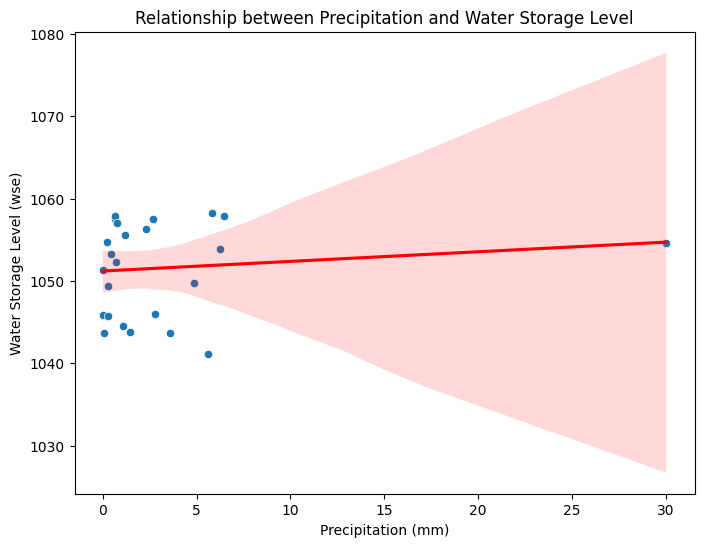

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x='precipitation_mm', y='wse')
sns.regplot(data=merged_df, x='precipitation_mm', y='wse', scatter=False, color='red')
plt.title('Relationship between Precipitation and Water Storage Level')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Water Storage Level (wse)')
plt.show()


In [11]:
import plotly.express as px
import pandas as pd

merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])

fig = px.scatter(
    merged_df,
    x='precipitation_mm',
    y='wse',
    title='Impact of Precipitation on Water Storage Level at Masinga Dam',
    labels={'precipitation_mm': 'Precipitation (mm)', 'wse': 'Water Storage Level (m)'}
    # No trendline here
)

fig.show()


### Impact of Extreme Temperatures on Water Levels

In [24]:
import pandas as pd
import plotly.express as px

# Use your merged dataframe variable here
df = merged_df.copy()

# Define extreme temperature thresholds (top and bottom 10%)
temp_low = df['temperature_C'].quantile(0.10)
temp_high = df['temperature_C'].quantile(0.90)

# Categorize temperature extremes
def categorize_temp(temp):
    if temp <= temp_low:
        return 'Low Extreme'
    elif temp >= temp_high:
        return 'High Extreme'
    else:
        return 'Normal'

df['temp_category'] = df['temperature_C'].apply(categorize_temp)

# Box plot of water storage levels (wse) by temperature category
fig = px.box(
    df,
    x='temp_category',
    y='wse',
    title='Impact of Extreme Temperature Events on Water Storage Levels',
    labels={'temp_category': 'Temperature Category', 'wse': 'Water Storage Level (m)'}
)

fig.show()


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your merged dataframe is named df and datetime is parsed
df['datetime'] = pd.to_datetime(df['datetime'])

# 1. Seasonal trend: Water storage over time (monthly average)
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
monthly_wse = df.groupby(['year', 'month'])['wse'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_wse, x='month', y='wse', hue='year', palette='tab10')
plt.title('Monthly Average Water Storage Levels (Masinga Dam)')
plt.xlabel('Month')
plt.ylabel('Water Storage Level (wse)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 2. Precipitation vs Water Levels
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='precipitation_mm', y='wse')
sns.regplot(data=df, x='precipitation_mm', y='wse', scatter=False, color='red')
plt.title('Precipitation vs Water Storage Level')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Water Storage Level (wse)')
plt.show()

# 3. Impact of Extreme Temperatures on Water Levels
# Define temperature extremes
temp_low = df['temperature_C'].quantile(0.10)
temp_high = df['temperature_C'].quantile(0.90)

df['temp_category'] = pd.cut(df['temperature_C'], bins=[-100, temp_low, temp_high, 100], labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='temp_category', y='wse')
plt.title('Water Storage Level by Temperature Category')
plt.xlabel('Temperature Category')
plt.ylabel('Water Storage Level (wse)')
plt.show()

# Continue similarly for other questions...


ModuleNotFoundError: No module named 'pandas'

In [21]:
import plotly.graph_objects as go
import pandas as pd

# Calculate 90th percentile temperature as threshold for extreme temperature
temp_threshold = merged_df['temperature_C'].quantile(0.9)

# Create a new column for extreme temperature days
merged_df['extreme_temp'] = merged_df['temperature_C'] >= temp_threshold

# Sort dataframe by datetime
merged_df = merged_df.sort_values('datetime')

# Plot water storage level over time
fig = go.Figure()

# Water storage line
fig.add_trace(go.Scatter(
    x=merged_df['datetime'],
    y=merged_df['wse'],
    mode='lines',
    name='Water Storage Level (wse)'
))

# Highlight points with extreme temperature
fig.add_trace(go.Scatter(
    x=merged_df.loc[merged_df['extreme_temp'], 'datetime'],
    y=merged_df.loc[merged_df['extreme_temp'], 'wse'],
    mode='markers',
    marker=dict(color='red', size=8),
    name='Extreme Temperature Days'
))

fig.update_layout(
    title='Water Storage Level and Extreme Temperature Events',
    xaxis_title='Date',
    yaxis_title='Water Storage Level (m)',
    hovermode='x unified'
)

fig.show()


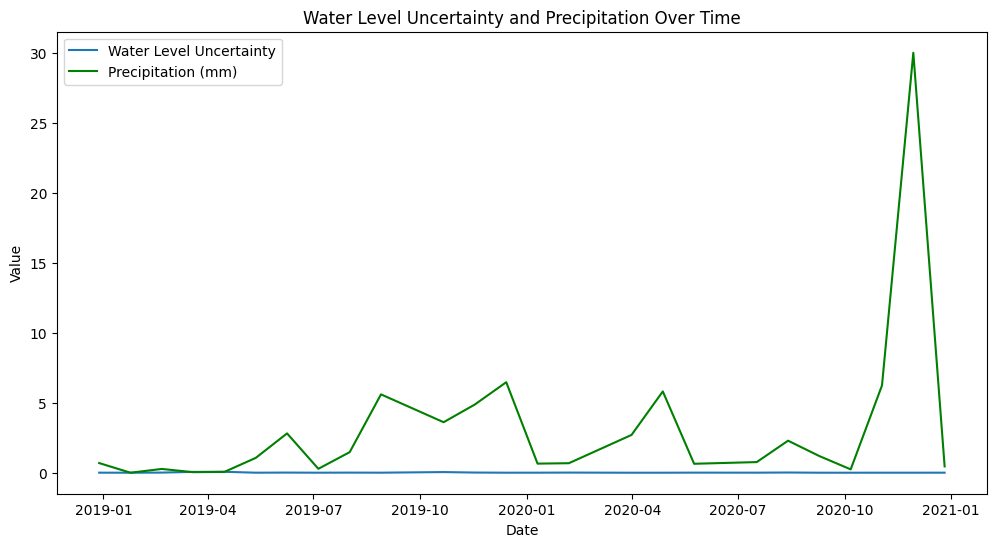

In [15]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='datetime', y='wse_u', label='Water Level Uncertainty')
sns.lineplot(data=df, x='datetime', y='precipitation_mm', color='green', label='Precipitation (mm)')
plt.title('Water Level Uncertainty and Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


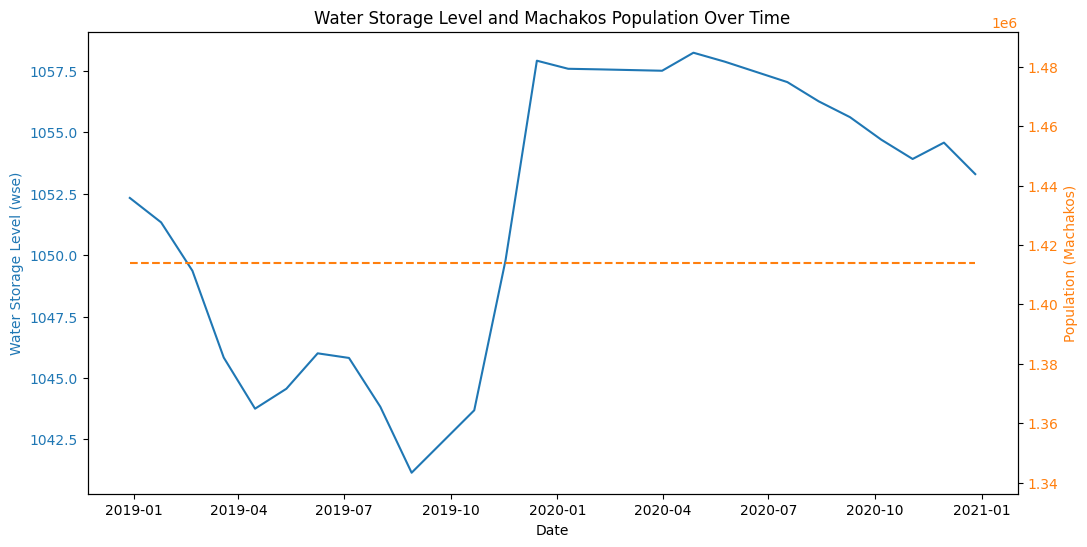

In [16]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Storage Level (wse)', color=color)
ax1.plot(df['datetime'], df['wse'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Population (Machakos)', color=color)
ax2.plot(df['datetime'], df['population_machakos'], color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Water Storage Level and Machakos Population Over Time')
plt.show()


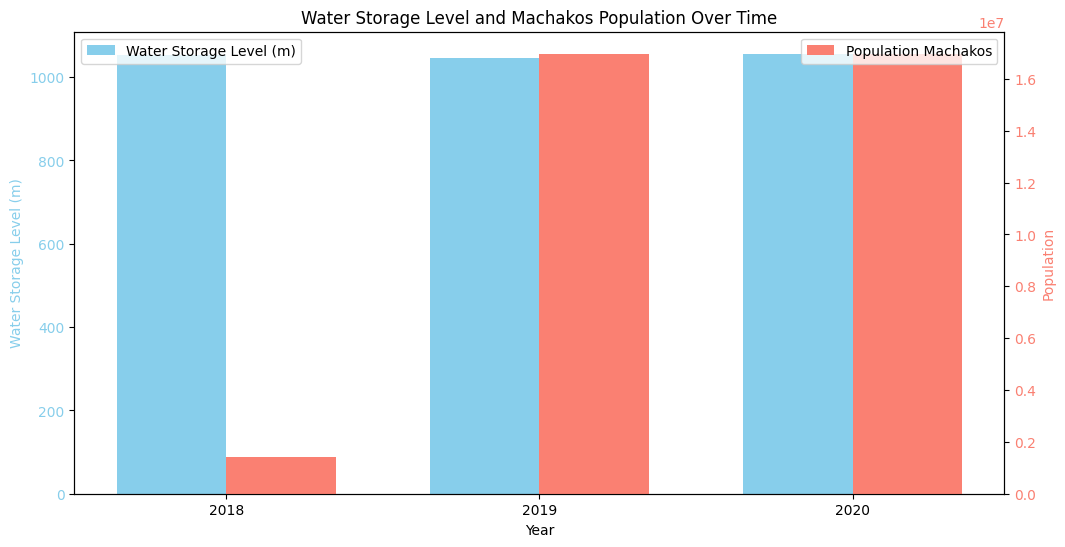

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate data by year
data = merged_df.groupby('year').agg({
    'wse': 'mean',  # average water storage level per year
    'population_machakos': 'sum'  # total population per year
}).reset_index()

years = data['year']
water_levels = data['wse']
populations = data['population_machakos']

x = np.arange(len(years))  # label locations
width = 0.35  # width of the bars

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar for water storage level
bars1 = ax1.bar(x - width/2, water_levels, width, label='Water Storage Level (m)', color='skyblue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Water Storage Level (m)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Create second y-axis for population
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, populations, width, label='Population Machakos', color='salmon')
ax2.set_ylabel('Population', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

# Title and x-axis labels
plt.title('Water Storage Level and Machakos Population Over Time')
plt.xticks(x, years)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


ValueError: Could not interpret value `Avg Household size` for `x`. An entry with this name does not appear in `data`.

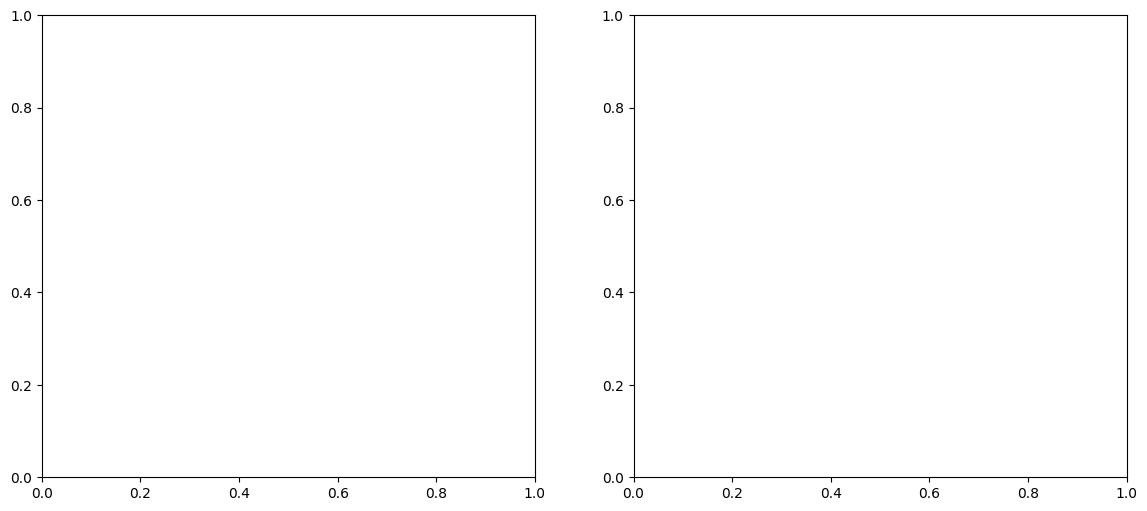

In [17]:
# Scatter plots to explore relationship
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.scatterplot(x='Avg Household size', y='wse', data=df, ax=axes[0])
axes[0].set_title('Avg Household Size vs Water Storage Level')
axes[0].set_xlabel('Average Household Size')
axes[0].set_ylabel('Water Storage Level (wse)')

sns.scatterplot(x='No.of Households', y='wse', data=df, ax=axes[1])
axes[1].set_title('Number of Households vs Water Storage Level')
axes[1].set_xlabel('Number of Households')
axes[1].set_ylabel('Water Storage Level (wse)')

plt.tight_layout()
plt.show()


In [28]:
print(df.columns)


Index(['date_x', 'temperature_C', 'precipitation_mm', 'datetime', 'wse',
       'wse_u', 'population_machakos', 'month', 'year', 'extreme_temp',
       'temp_category'],
      dtype='object')


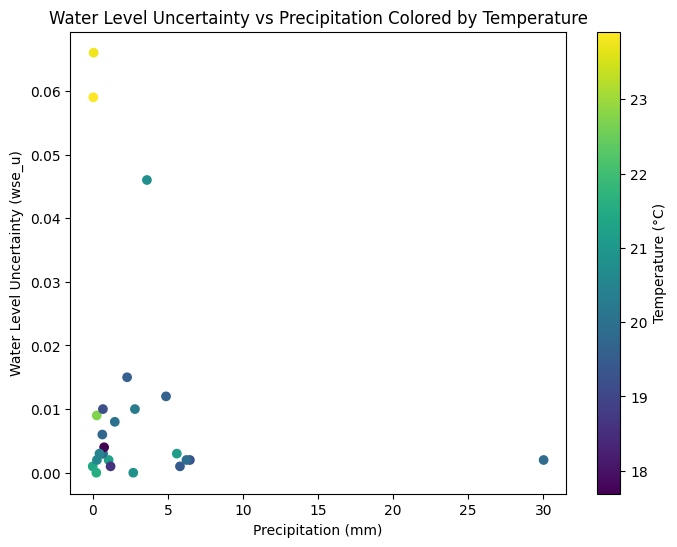

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Create scatter with color mapping to temperature
sc = plt.scatter(df['precipitation_mm'], df['wse_u'], c=df['temperature_C'], cmap='viridis')

plt.xlabel('Precipitation (mm)')
plt.ylabel('Water Level Uncertainty (wse_u)')
plt.title('Water Level Uncertainty vs Precipitation Colored by Temperature')

# Add colorbar based on the scatter plot colors
plt.colorbar(sc, label='Temperature (°C)')

plt.show()
